In [3]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
import numpy as np

sns.set(style="whitegrid")

In [4]:
# Carrega o conjunto de dados Titanic diretamente de um repositório no GitHub
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Seleciona apenas as colunas 'Sex', 'Pclass' e 'Survived', e remove linhas com valores ausentes (NaN)
df = df[['Sex', 'Pclass', 'Survived']].dropna()

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Sexo'] = df['Sex'].map({0: 'Homem', 1: 'Mulher'})
df['Classe'] = df['Pclass'].astype(str)
df['Sobreviveu'] = df['Survived'].map({0: 'Não', 1: 'Sim'})

C:\Users\jmarques\AppData\Local\Temp\ipykernel_7708\3978351522.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='Set2')


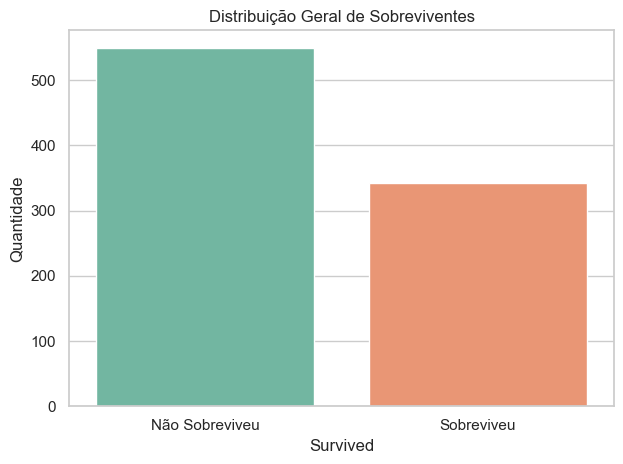

In [8]:
# plot da distribuição geral de sobreviventes
sns.countplot(x='Survived', data=df, palette='Set2')
plt.title("Distribuição Geral de Sobreviventes")
plt.xticks([0, 1], ['Não Sobreviveu', 'Sobreviveu'])
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

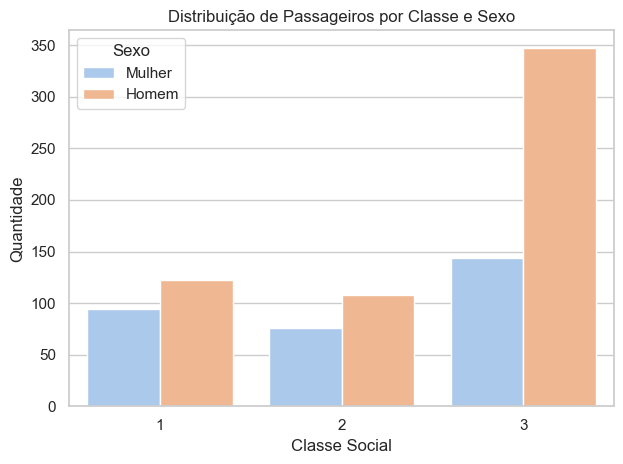

In [6]:
# plot da distribuição por classe e sexo
sns.countplot(x='Pclass', hue='Sexo', data=df, palette='pastel')
plt.title("Distribuição de Passageiros por Classe e Sexo")
plt.xlabel("Classe Social")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

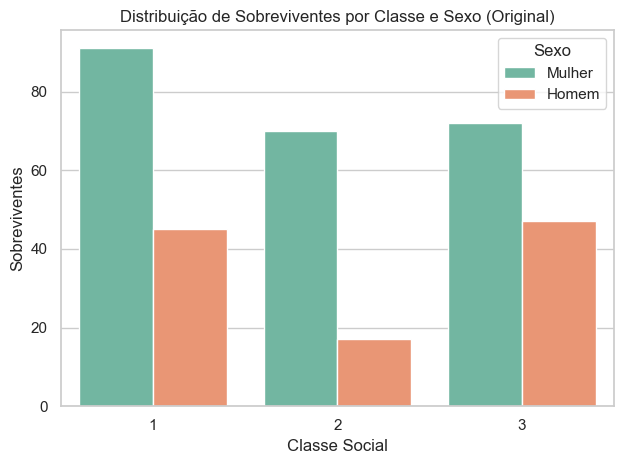

In [9]:
# Sobreviventes por classe e sexo
sobreviventes = df[df['Survived'] == 1]
sns.countplot(x='Pclass', hue='Sexo', data=sobreviventes, palette='Set2')
plt.title("Distribuição de Sobreviventes por Classe e Sexo (Original)")
plt.xlabel("Classe Social")
plt.ylabel("Sobreviventes")
plt.tight_layout()
plt.show()

C:\Users\jmarques\AppData\Local\Temp\ipykernel_7708\2932129216.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=proporcao, palette='Blues_d')


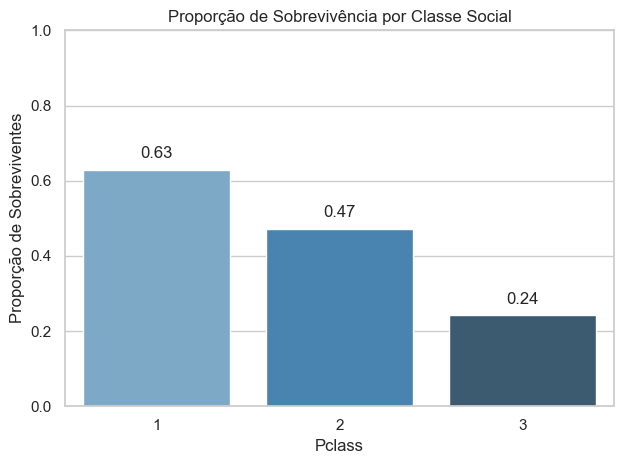

In [10]:
# Proporção de sobreviventes por classe
proporcao = df.groupby('Pclass')['Survived'].mean().reset_index()
sns.barplot(x='Pclass', y='Survived', data=proporcao, palette='Blues_d')
plt.title("Proporção de Sobrevivência por Classe Social")
plt.ylabel("Proporção de Sobreviventes")
plt.ylim(0, 1)
for i, val in enumerate(proporcao['Survived']):
    plt.text(i, val + 0.03, f"{val:.2f}", ha='center')
plt.tight_layout()
plt.show()

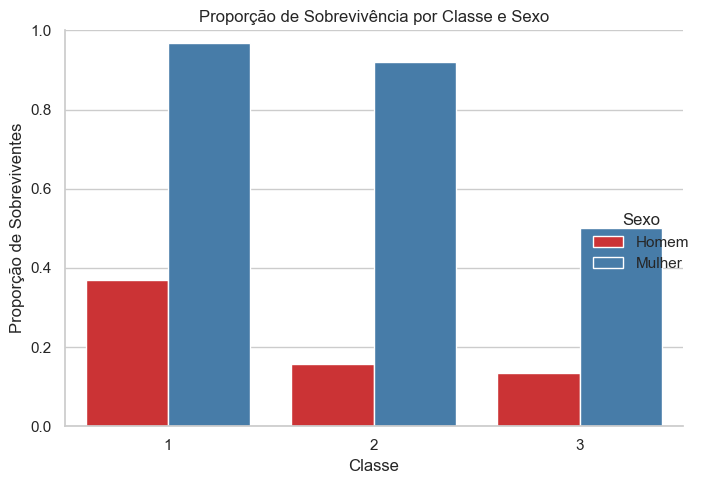

In [11]:
# Proporção de sobreviventes por classe e sexo
proporcao_sexo_classe = df.groupby(['Classe', 'Sexo'])['Survived'].mean().reset_index()
sns.catplot(data=proporcao_sexo_classe, x='Classe', y='Survived', hue='Sexo', kind='bar', palette='Set1', height=5, aspect=1.2)
plt.title("Proporção de Sobrevivência por Classe e Sexo")
plt.ylim(0, 1)
plt.ylabel("Proporção de Sobreviventes")
plt.tight_layout()
plt.show()

In [13]:
#Balanceamento do dataset

df_balanced = pd.DataFrame() 
# Itera sobre cada classe (1ª, 2ª, 3ª) e filtra
for pclass in df['Pclass'].unique(): 
    subset = df[df['Pclass'] == pclass]  # Filtra os dados da classe atual
    survived = subset[subset['Survived'] == 1]  # Filtra os passageiros que sobreviveram
    not_survived = subset[subset['Survived'] == 0]  # Filtra os passageiros que não sobreviveram
    min_len = min(len(survived), len(not_survived))  # Determina o menor grupo para balancear
    balanced_subset = pd.concat([  # Cria subconjunto balanceado por classe
        resample(survived, replace=False, n_samples=min_len, random_state=42),  # Amostra sobreviventes
        resample(not_survived, replace=False, n_samples=min_len, random_state=42)  # Amostra não sobreviventes
    ])
    df_balanced = pd.concat([df_balanced, balanced_subset])  # Adiciona ao DataFrame final

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Embaralha os dados e redefine os índices


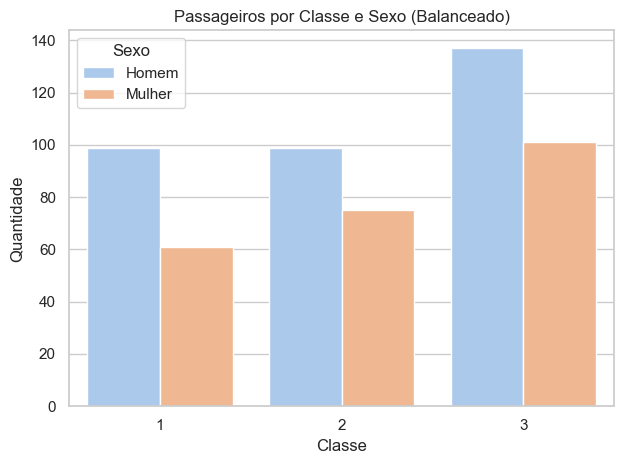

In [14]:
#Gráficos pós-balanceamento

# Passageiros por classe e sexo
sns.countplot(x='Pclass', hue='Sexo', data=df_balanced, palette='pastel')
plt.title("Passageiros por Classe e Sexo (Balanceado)")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()


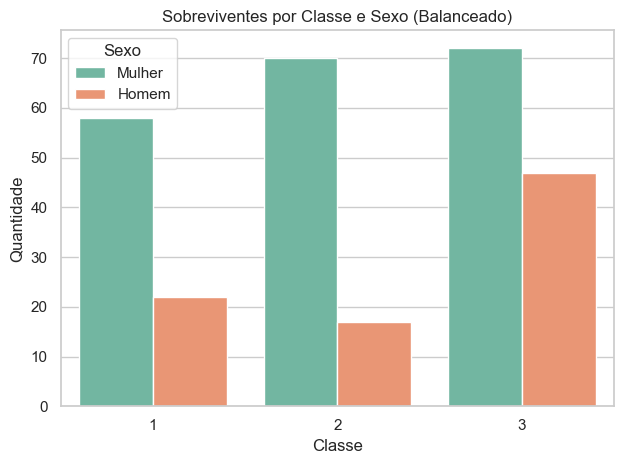

In [15]:
# Sobreviventes por classe e sexo (balanceado)
sobreviventes_bal = df_balanced[df_balanced['Survived'] == 1]
sns.countplot(x='Pclass', hue='Sexo', data=sobreviventes_bal, palette='Set2')
plt.title("Sobreviventes por Classe e Sexo (Balanceado)")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

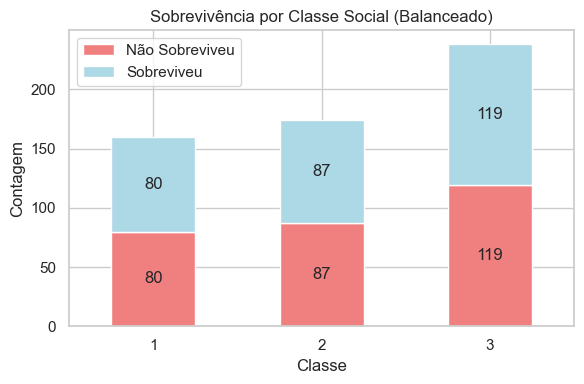

In [16]:
# Stacked bar – sobrevivência por classe
counts = df_balanced.groupby('Pclass')['Survived'].value_counts().unstack().fillna(0)
counts.columns = ['Não Sobreviveu', 'Sobreviveu']
ax = counts.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'], figsize=(6,4))
plt.title("Sobrevivência por Classe Social (Balanceado)")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.xticks(rotation=0)
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.tight_layout()
plt.show()


In [17]:
# Separação e normalização

X = df_balanced[['Sex', 'Pclass']]  # Seleciona as variáveis independentes (features)
y = df_balanced['Survived']  # Seleciona a variável alvo (target)

X_train, X_test, y_train, y_test = train_test_split(  # Divide os dados em treino e teste
    X, y, test_size=0.2, random_state=42)  # 80% treino, 20% teste

scaler = StandardScaler()  # Inicializa o normalizador (padronização)

X_train_scaled = scaler.fit_transform(X_train)  # Ajusta e transforma os dados de treino
X_test_scaled = scaler.transform(X_test)  # Transforma os dados de teste com o mesmo ajuste


In [19]:
# classificador MLP (rede neural)
mlp = MLPClassifier( 
    hidden_layer_sizes=(16, 8), 
    activation='relu',  
    solver='adam',  # Otimizador Adam (baseado em gradiente)
    max_iter=180,  
    random_state=42,  
    early_stopping=False,  # Não interrompe o treino automaticamente se não houver melhoria
    verbose=True, 
)

mlp.fit(X_train_scaled, y_train)  # Treina o modelo com os dados de treino normalizados

Iteration 1, loss = 0.80333930
Iteration 2, loss = 0.79339789
Iteration 3, loss = 0.78372205
Iteration 4, loss = 0.77467648
Iteration 5, loss = 0.76584092
Iteration 6, loss = 0.75718384
Iteration 7, loss = 0.74892729
Iteration 8, loss = 0.74118310
Iteration 9, loss = 0.73365802
Iteration 10, loss = 0.72720148
Iteration 11, loss = 0.72060977
Iteration 12, loss = 0.71447992
Iteration 13, loss = 0.70891076
Iteration 14, loss = 0.70399361
Iteration 15, loss = 0.69898154
Iteration 16, loss = 0.69431398
Iteration 17, loss = 0.68961329
Iteration 18, loss = 0.68577561
Iteration 19, loss = 0.68179104
Iteration 20, loss = 0.67784539
Iteration 21, loss = 0.67404007
Iteration 22, loss = 0.67015053
Iteration 23, loss = 0.66652697
Iteration 24, loss = 0.66262253
Iteration 25, loss = 0.65882019
Iteration 26, loss = 0.65495647
Iteration 27, loss = 0.65115437
Iteration 28, loss = 0.64736046
Iteration 29, loss = 0.64364724
Iteration 30, loss = 0.63986439
Iteration 31, loss = 0.63620443
Iteration 32, los

c:\Users\jmarques\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(16, 8), max_iter=180, random_state=42,
              verbose=True)

In [20]:
# Avaliação

y_pred = mlp.predict(X_test_scaled)  

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}") 
print("\nRelatório de Classificação:") 
print(classification_report(y_test, y_pred))  


Acurácia: 0.8000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.93      0.83        59
           1       0.90      0.66      0.76        56

    accuracy                           0.80       115
   macro avg       0.82      0.80      0.79       115
weighted avg       0.82      0.80      0.80       115

